# Background

* [0. What is drift?](#0.-What-is-drift?)

* [1. Detecting drift](#1.-Detecting-drift)
    * [Hypothesis testing](#Hypothesis-testing)
    * [Dimension reduction](#Dimension-reduction)
    * [Input preprocessing](#Input-preprocessing)
    * [Simple example](#Simple-example)
  
* [2. Learned drift detection](#2.-Learned-drift-detection)
    * [Learned kernel](#Learned-kernel)
    * [Classifier](#Classifier)
    * [Spot-the-diff](#Spot-the-diff)
    * [Model uncertainty](#Model-uncertainty)    

* [3. Online drift detection](#3.-Online-drift-detection)
    * [Online drift detectors](#Online-drift-detectors)
    * [Expected run-time and detection delay](#Expected-run-time-and-detection-delay)

## 0. What is drift?

Although powerful, modern machine learning models can be sensitive. Seemingly subtle changes in a data distribution can destroy the performance of otherwise state-of-the art models, which can be especially problematic when ML models are deployed in production. Typically, ML models are tested on held out data in order to estimate their future performance. Crucially, this assumes that the *process* underlying the input data $\mathbf{X}$ and output data $\mathbf{Y}$ remains constant. 

*Drift* is said to occur when the process underlying $\mathbf{X}$ and $\mathbf{Y}$ at test time differs from the process that generated the training data. In this case, we can no longer expect the model's performance on test data to match that observed on held out training data. If a *ground truth* is available at test time, *supervised drift detection* can be performed, with the model's predictive performance monitored directly. However, in many scenarios, such as the binary classification example below, a ground truth is not available and *unsupervised drift detection* methods are required.

![drift in deployment](images/drift_deployment.png) 

To explore the different types of drift, consider the common scenario where we have input data $\mathbf{X}$ and output data $\mathbf{Y}$, jointly distributed according to $P(\mathbf{X},\mathbf{Y})$, and a model $f: \boldsymbol{x} \mapsto y$ trained on training data drawn from a distribution $P_{ref}(\mathbf{X},\mathbf{Y})$. *Drift* is said to have occured when $P(\mathbf{X},\mathbf{Y}) \ne P_{ref}(\mathbf{X},\mathbf{Y})$. Writing the joint distribution as

$$
P(\mathbf{X},\mathbf{Y}) = P(\mathbf{Y}|\mathbf{X})P(\mathbf{X}) = P(\mathbf{X}|\mathbf{Y})P(\mathbf{Y}),
$$

we can classify drift under a number of types:

- **Covariate drift**: Also referred to as input drift, this occurs when the distribution of the input data has shifted $P(\mathbf{X}) \ne P_{ref}(\mathbf{X})$, whilst $P(\mathbf{Y}|\mathbf{X})$ = $P_{ref}(\mathbf{Y}|\mathbf{X})$. The model may now be extrapolating, potentially resulting in unreliable predictions. 

- **Prior drift**: Also referred to as label drift, this occurs when the distribution of the outputs has shifted $P(\mathbf{Y}) \ne P_{ref}(\mathbf{Y})$, whilst $P(\mathbf{X}|\mathbf{Y})=P_{ref}(\mathbf{X}|\mathbf{Y})$. The model could still be accurate, but accuracy metrics might be affected. 

- **Concept drift**: This occurs when the process generating $y$ from $x$ has changed, such that $P(\mathbf{Y}|\mathbf{X}) \ne P_{ref}(\mathbf{Y}|\mathbf{X})$. It is possible that the model might no longer give a suitable approximation of the true process. 

Note that a change in one of the conditional probabilities $P(\mathbf{X}|\mathbf{Y})$ and $P(\mathbf{Y}|\mathbf{X})$ does not necessarily imply a change in the other. For example, consider the pneumonia prediction example from [Lipton et al.](https://arxiv.org/pdf/1802.03916.pdf), whereby a classification model $f$ is trained to predict $y$, the occurance (or not) of pneumonia, given a list of symptoms $\boldsymbol{x}$. During a pneumonia outbreak, $P(\mathbf{Y}|\mathbf{X})$ (e.g. pneumonia given cough) might rise, but the manifestations of
the disease $P(\mathbf{X}|\mathbf{Y})$ might not change.

Below, the different types of drift are visualised for a simple two-dimensional classification problem. It is possible for a drift to fall under more than one category, for example the *prior drift* below also happens to be a case of *covariate drift*. 

![2d drift example](images/bg_2d_drift.png) 

It is relatively easy to spot drift by eyeballing these figures here. However, the task becomes considerably harder for high-dimensional real problems, especially since real-time ground truths are not typically available. Some types of drift, such as prior and concept drift, are also difficult to detect without access to ground truths. As a workaround proxies are required, for example a model's predictions can be monitored to check for prior drift.  

## 1. Detecting drift <a class="anchor" id="drift_detection"></a>

[Alibi Detect](https://github.com/SeldonIO/alibi-detect) offers a wide array of methods for detecting drift (see [here](../overview/algorithms.md)), some of which are examined in the NeurIPS 2019 paper [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953). Generally, these aim to determine whether the distribution $P(\mathbf{x})$ has drifted from a reference distribution $P_{ref}(\mathbf{x})$, where $\mathbf{x}$ may represent input data $\mathbf{X}$, true output data $\mathbf{Y}$, or some form of model output, depending on what type of drift we wish to detect. 

Due to natural randomness in the process being modelled, we don't necessarily expect observations $\mathbf{x}_1,\dots,\mathbf{x}_N$ drawn from $P(\mathbf{x})$ to be identical to $\mathbf{x}^{ref}_1,\dots,\mathbf{x}^{ref}_M$ drawn from $P_{ref}(\mathbf{x})$. To decide whether differences between $P(\mathbf{x})$ and $P_{ref}(\mathbf{x})$ are due to drift or just natural randomness in the data, *statistical two-sample hypothesis* testing is used, with the null hypothesis $P(\mathbf{x})=P_{ref}(\mathbf{x})$. If the $p$-value obtained is below a given threshold, the null is rejected and the alternative hypothesis $P(\mathbf{x}) \ne P_{ref}(\mathbf{x})$ is accepted, suggesting drift is occuring.  

Since $\mathbf{x}$ is often high-dimensional (even a 200 x 200 greyscale image has 40k dimensions!), performing hypothesis testing in the full-space is often either computationally intractable, or unsuitable for the chosen statistical test. Instead, the pipeline below is often used, with dimension reduction as a pre-processing step.

![drift detection pipeline](images/drift_pipeline.png) 
*Figure inspired by Figure 1 in <a href="https://arxiv.org/pdf/1810.11953.pdf">Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift</a>.*

### Hypothesis testing

Hypothesis testing involves first choosing a *test statistic* $S(\mathbf{x})$, which is expected to be small if the null hypothesis $H_0$ is true, and large if the alternative $H_a$ is true. For observed data $\mathbf{x}$, $S(\mathbf{x})$ is computed, followed by a $p$-value $\hat{p} = P(\text{such an extreme } S(\mathbf{x}) | H_0)$. In other words, $\hat{p}$ represents the probability of such an extreme value of $S(\mathbf{x})$ occuring given that $H_0$ is true. Typically results are said to be *statistically significant*, and the null $P(\mathbf{x})=P_{ref}(\mathbf{x})$ is rejected, when $\hat{p}\le \alpha$. Conveniently, the threshold $\alpha$ represents the desired false positive rate. 

The *test statistics* available in [Alibi Detect](https://github.com/SeldonIO/alibi-detect) can be broadly split into two categories; univariate and multivariate tests.

* Univariate:
    * [Chi-Squared](methods/chisquaredrift.ipynb) (for categorical data)
    * [Kolmogorov-Smirnov](methods/ksdrift.ipynb)

* Multivariate:
    * [Least-Squares Density Difference (LSDD)](methods/lsdddrift.ipynb)
    * [Maximum Mean Discrepancy (MMD)](methods/mmddrift.ipynb)

When applied to multidimensional data with dimension $d$, the univariate tests are applied in a feature-wise manner. The obtained $p$-values for each feature are aggregated either via the [Bonferroni](https://mathworld.wolfram.com/BonferroniCorrection.html) or the [False Discovery Rate](http://www.math.tau.ac.il/~ybenja/MyPapers/benjamini_hochberg1995.pdf) (FDR) correction. The Bonferroni correction is more conservative and controls for the probability of at least one false positive. The FDR correction on the other hand allows for an expected fraction of false positives to occur. 

Since the univariate tests examine the feature-wise marginal distributions, they may miss drift in cases where the joint distribution over all $d$ features has changed, but the marginals have not. The multivariate tests, which use permutation testing to extract $p$-values, offer a more powerful alternative at the cost of greater complexity.

### Dimension reduction

Given an input dataset $\mathbf{X}\in \mathbb{R}^{N\times d}$, where $N$ is the number of observations and $d$ the number of dimensions, the aim is to reduce the data dimensionality from $d$ to $K$, where $K\ll d$. The lower dimensional data $\hat{\mathbf{X}}\in \mathbb{R}^{N\times K}$ is then monitored by the drift detector. The paper [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953) presents a number of dimension reduction approaches, which can be broadly categorised under:

1. Linear projections
2. Non-linear projections
3. Feature maps (from ML model)

[Alibi Detect](https://github.com/SeldonIO/alibi-detect) allows for a high degree of flexibility here, with a user's chosen dimension reduction technique able to be incorperated into their chosen detector via the `preprocess_fn` argument (and sometimes `preprocess_batch_fn` and `preprocess_x_ref`, depending on the detector). In the following sections, the three categories of techniques are briefily introduced. Alibi Detect offers the following functionality using either [TensorFlow](https://www.tensorflow.org/) or [PyTorch](https://pytorch.org/) backends and preprocessing utilities. For more details, see the [examples](examples.rst). 


#### Linear projections 

This includes dimension reduction techniques such as [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) and [sparse random projections (SRP)](https://doi.org/10.1145/1150402.1150436). These techniques involve using a transformation or projection matrix $\mathbf{R}$ to reduce the dimensionality of a given data matrix $\mathbf{X}$, such that $\hat{\mathbf{X}} = \mathbf{XR}$. A straightforward way to include such techniques as a pre-processing stage is to pass them to the detectors via the `preprocess_fn` argument, for example for the `scikit-learn` library's `PCA` class: 

```python
pca = PCA(2)
pca.fit(X_train)
detector = MMDDrift(X_ref, backend='tensorflow', p_val=.05, preprocess_fn=pca.transform)
```

#### Non-linear projections

A common strategy for obtaining non-linear dimension reducing representations is to use an autoencoder, but other [non-linear techniques](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction) can also be used. Autoencoders consist of an encoder function $\phi : \mathcal{X} \mapsto \mathcal{H}$ and a decoder function $\psi : \mathcal{H} \mapsto \mathcal{X}$, where the latent space $\mathcal{H}$ has lower dimensionality than the input space $\mathcal{X}$. The output of the encoder $\hat{\mathbf{X}} \in \mathcal{H}$ can then be monitored by the drift detector. Training involves learning both the encoding function $\phi$ and the decoding function $\psi$, in order to reduce the reconstruction loss, e.g. if MSE is used: $\phi, \psi = \text{arg} \min_{\phi, \psi}\, \lVert \mathbf{X}-(\phi \circ \psi)\mathbf{X}\rVert^2$. However, untrained (randomly initialised) autoencoders can also be used. For an example, a `pytorch` autoencoder can be incorporated into a detector by packaging it as a callable function using `preprocess_drift` (from [alibi_detect.cd.pytorch.preprocess](../api/alibi_detect.cd.pytorch.preprocess.rst)) and `partial` (see [here](https://docs.python.org/3/library/functools.html#functools.partial)):

```python
encoder_net = torch.nn.Sequential(...)
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=512)
detector = MMDDrift(X_ref, backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn)
```

  
#### Feature maps

Following [Detecting and Correcting for Label Shift with Black Box Predictors](https://arxiv.org/abs/1802.03916), feature maps can be extracted from existing pre-trained black-box models such as the image classifier shown below. Instead of using the latent space as the dimensionality-reducing representation, other layers of the model such as the softmax outputs or predicted class-labels can also be extracted and monitored. Since different layers yield different output dimensions, different hypothesis tests are required for each.

![BBSD](images/BBSD.png) 
*Figure inspired by this <a href="https://github.com/octoenergy/timeserio/blob/44f05ac86b7683b4bedf598e99941cb9f8bf04bf/docs/source/examples/MNIST.ipynb">MNIST classification example</a> from the timeserio package.*

[Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953) shows that extracting feature maps from existing models can be an effective technique, which is encouraging since this allows the user to repurpose existing black-box models for use as drift detectors. The syntax for incorporating existing models into drift detectors is similar to the previous autoencoder example, with the added step of using `HiddenOutput` ([alibi_detect.cd.tensorflow.preprocess](../api/alibi_detect.cd.tensorflow.preprocess.rst) or [alibi_detect.cd.pytorch.preprocess](../api/alibi_detect.cd.pytorch.preprocess.rst)) to select the model's network layer to extract outputs from. The code snippet below is borrowed from [Maximum Mean Discrepancy drift detector on CIFAR-10](../examples/cd_mmd_cifar10.ipynb), where the softmax layer of the well-known [ResNet-32](https://arxiv.org/pdf/1512.03385.pdf) model is fed into an `MMDDrift` detector.

```python
clf = fetch_tf_model('cifar10', 'resnet32')
preprocess_fn = partial(preprocess_drift, model=HiddenOutput(clf, layer=-1), batch_size=128)
detector = MMDDrift(X_ref, backend='tensorflow', p_val=.05,preprocess_fn=preprocess_fn)
```

<div class="alert alert-info">

**Note 1: Disjoint training and reference data sets**
    
Astute readers may have noticed that in the linear projection example above, the data `X_train` is used to "train" the `PCA` model, but the `MMDDrift` detector is initialised with `X_ref`. This is a subtle yet important point. If a detector's preprocessor (a [dimension reduction](#Dimension-reduction) or other [input preprocessing](#Input-preprocessing) step) is trained on the reference data (`X_ref`), any over-fitting to this data may make the resulting detector overly sensitive to differences between the reference and test data sets. 
    
To avoid an overly discriminative detector, it is customary to draw two disjoint datasets from $P_{ref}(\mathbf{x})$, a training set and a held-out reference set. **The training data is used to train any input preprocessing steps, and the detector is then initialised on the reference set**, and used to detect drift between the reference and test set. This also applies to the [learned drift detectors](#2.-Learned-drift-detection), which should be trained on the training set not the reference set. 
    
</div>

### Input preprocessing

Dimension reduction is a common preprocessing task (e.g. for covariate drift detection on tabular or image data), but some modalities of data (e.g. text and graph data) require other forms of preprocessing in order for drift detection to be performed effectively. 

#### Text data

When dealing with text data, performing drift detection on raw strings or tokenized data is not effective since they don't represent the semantics of the input. Instead, we extract contextual embeddings from language transformer models and detect drift on those. This procedure has a significant impact on the type of drift we detect. Strictly speaking we are not detecting covariate/input drift anymore since the entire training procedure (objective function, training data etc) for the (pre)trained embeddings has an impact on the embeddings we extract.

![BERT-schematic](images/BERT.png)
*Figure based on Jay Alammar's excellent [visual guide](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) to the BERT model*

Alibi Detect contains functionality to leverage pre-trained embeddings from HuggingFace’s [transformer](https://huggingface.co/transformers/) package. Popular models such as [BERT](https://arxiv.org/abs/1810.04805) or [DistilBERT](https://arxiv.org/abs/1910.01108) (shown above) can be used, but Alibi Detect also allows you to easily use your own embeddings of choice. A subsequent dimension reduction step can also be applied if neccesary, as is done in the [Text drift detection on IMDB movie reviews](../examples/cd_text_imdb.nblink) example, where the 768-dimensional embeddings from the BERT model are passed through an untrained AutoEncoder to reduce their dimensionality. Alibi Detect allows various types of embeddings to be extracted from transformer models, as discussed in [alibi_detect.models.tensorflow.embedding](../api/alibi_detect.models.tensorflow.embedding.rst).

#### Graph data

In a similar manner to text data, graph data requires preprocessing before drift detection can be performed. This can be done by extracting graph embeddings from graph neural network (GNN) encoders, as shown below, and demonstrated in the [Drift detection on molecular graphs](../examples/cd_mol.nblink) example.

<br>
<div style="text-align: center">
<img src="images/graph_embedding.png" width="550"/>
</div>

### Simple example

For a simple example, we'll use the [MMD detector](methods/mmddrift.ipynb) to check for drift on the two-dimensional binary classification problem shown previously. The MMD detector is a kernel-based method for multivariate two sample testing. Since the number of dimensions is already low, dimension reduction step is not necessary here here. For a more advanced example using the [MMD detector](methods/mmddrift.ipynb) with dimension reduction, check out the [Maximum Mean Discrepancy drift detector on CIFAR-10](../examples/cd_mmd_cifar10.nblink) example. 

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

The true model/process is defined as:

$$
y =
\begin{cases}
    1 & \text{if } x_2 > sx_1 \\
    0 & \text{otherwise}
\end{cases}
$$

where the slope $s$ is set as $s=-1$. 

In [2]:
def true_model(X,slope=-1):
    z = slope*X[:,0]
    idx = np.argwhere(X[:,1]>z)
    y = np.zeros(X.shape[0])
    y[idx] = 1
    return y

The 2D input data $\mathbf{x}=(x_1,x_2)$ is generated by sampling from a mixture of two Normal distributions:

$$
\mathbf{x} = \phi_1 \mathcal{N}\left(\left[-1,-1\right]^T, \sigma^2\mathbf{I} \right) +
\phi_2 \mathcal{N}\left(\left[1,1\right]^T, \sigma^2\mathbf{I} \right)
$$

with the standard deviation set at $\sigma=0.8$, and the weights set to $\phi_1=\phi_2=0.5$.

In [3]:
sigma = 0.8
ref_norm_0 = stats.multivariate_normal([-1,-1], np.eye(2)*sigma**2)
ref_norm_1 = stats.multivariate_normal([ 1, 1], np.eye(2)*sigma**2)

X_0 = ref_norm_0.rvs(size=120,random_state=1)
X_1 = ref_norm_1.rvs(size=120,random_state=1)
X_ref = np.vstack([X_0, X_1])

true_slope = -1
y_ref = true_model(X_ref,true_slope)

To save time later on, a plotting function is defined:

In [4]:
plt.rcParams.update({'font.size': 16})

def plot(X,y, slope, clf=None):
    # Init plot
    fig, ax = plt.subplots(figsize=(4,4))
    #ax.axis('equal')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_xlim([-3.5,3.5])
    ax.set_ylim([-6,3.3])
    
    # Plot data
    cmap = LinearSegmentedColormap.from_list('my_cmap', [(0.78,0.44,0.22), (0.22, 0.44, 0.78)], N=2)
    scat = ax.scatter(X[:,0], X[:,1],c=y,ec='k',s=70,cmap=cmap,alpha=0.7)
    
    # Plot true decision boundary
    xconcept = np.array(ax.get_xlim())
    ax.plot(xconcept,xconcept*slope,'k--',lw=2,alpha=0.8)
    
    if clf is not None:
        # Plot classifier decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xx = np.linspace(xlim[0], xlim[1], 100)
        yy = np.linspace(ylim[0], ylim[1], 100)
        XX, YY = np.meshgrid(xx, yy)
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3, levels=1)
        ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=[2,0], levels=1,alpha=0.8)

    plt.show()
    
labels = ['No','Yes']

For our model, we choose the well-known, but simple, decision tree classifier. As well as training the model, this is a good time to initialise the MMD detector with held-out reference data (see Note 1) by calling:

```python
detector = MMDDrift(X_ref, backend='tensorflow', p_val=.05)
```

The significance threshold is set at $\alpha=0.05$, meaning the detector will flag results as drift detected when the computed $p$-value is less than this i.e. $\hat{p}< \alpha$. 

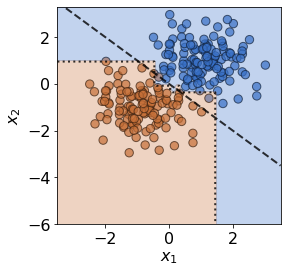

Mean training accuracy 99.17%
No GPU detected, fall back on CPU.


In [5]:
# Generate training data for the classifier.
X_0 = ref_norm_0.rvs(size=120,random_state=0)
X_1 = ref_norm_1.rvs(size=120,random_state=0)
X_train = np.vstack([X_0, X_1])
y_train = true_model(X_train,true_slope)

# Fit decision tree classifier
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X_train, y_train)

# Plot
plot(X_ref,y_ref,true_slope,clf=clf)

# Classifier accuracy
print('Mean training accuracy %.2f%%' %(100*clf.score(X_ref,y_ref)))

# Fit a drift detector to the training data
from alibi_detect.cd import MMDDrift
detector = MMDDrift(X_ref, backend='pytorch', p_val=.05)

#### No drift

Before introducing drift, we first examine the case where no drift is present. We resample from the same mixture of Gaussian distributions to generate test data. The individual data observations are different, but the underlying distributions are unchanged, hence no true drift is present. 

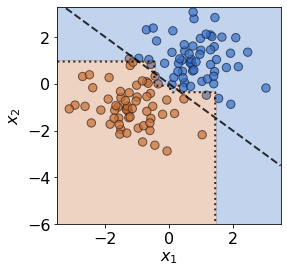

Mean test accuracy 95.00%


In [6]:
slope = true_slope

X_0 = ref_norm_0.rvs(size=60,random_state=2)
X_1 = ref_norm_1.rvs(size=60,random_state=2)
X_test = np.vstack([X_0, X_1])

# Plot
y_test = true_model(X_test,slope)
plot(X_test,y_test,slope,clf=clf)

# Classifier accuracy
print('Mean test accuracy %.2f%%' %(100*clf.score(X_test,y_test)))

Unsurprisingly, the model's mean test accuracy is relatively high. To run the detector on test data the `.predict()` is used:

In [7]:
detector.predict(X_test)

{'data': {'is_drift': 0,
  'distance': 0.0023595122654528344,
  'p_val': 0.30000001192092896,
  'threshold': 0.05,
  'distance_threshold': 0.008109889},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'backend': 'pytorch'}}

For the test statistic $S(\mathbf{x})$, the MMD detector uses the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) to compute unbiased estimates of $\text{MMD}^2$. The $\text{MMD}$ is a distance-based measure between the two distributions $P$ and $P_{ref}$, based on the mean embeddings $\mu$ and $\mu_{ref}$ in a reproducing kernel Hilbert space $F$:

$$
\text{MMD}^2\left(F, P, P_{ref}\right) = \lVert \mu - \mu_{ref} \rVert^2_{F}
$$

A $p$-value is then obtained via a [permutation test](https://en.wikipedia.org/wiki/Resampling_(statistics)) on the values of $\text{MMD}^2$. As expected, since we are sampling from the reference distribution $P_{ref}(\mathbf{x})$, the detector's prediction is `'is_drift':0` here, indicating that drift is not detected. More specifically, the detector's $p$-value (`p_val`) is above the threshold of $\alpha=0.05$ (`threshold`), indicating that no statistically significant drift has been detected. The `.predict()` method also returns $\hat{S}(\mathbf{x})$ (`distance_threshold`), which is the threshold in terms of the test statistic $S(\mathbf{x})$ i.e. when $S(\mathbf{x})\ge \hat{S}(\mathbf{x})$ statistically significant drift has been detected. 

#### Covariate and prior drift 

To impose covariate drift, we apply a shift to the mean of one of the normal distributions:

$$
\mathbf{x}^* = \phi_1 \mathcal{N}\left(\left[-1\color{red}{+3},-1\color{red}{-3}\right]^T, \sigma^2\mathbf{I} \right) +
\phi_2 \mathcal{N}\left(\left[1,1\right]^T, \sigma^2\mathbf{I} \right)
$$


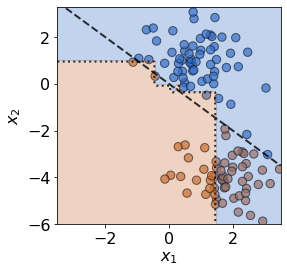

Mean test accuracy 66.67%
Is drift? Yes!


In [8]:
slope = -1.0

shift_norm_0 = stats.multivariate_normal([2, -4], np.eye(2)*sigma**2)
X_0 = shift_norm_0.rvs(size=60,random_state=2)
X_1 = ref_norm_1.rvs(size=60,random_state=2)
X_test = np.vstack([X_0, X_1])

# Plot
y_test = true_model(X_test,slope)
plot(X_test,y_test,slope,clf=clf)

# Classifier accuracy
print('Mean test accuracy %.2f%%' %(100*clf.score(X_test,y_test)))

# Check for drift in covariates
pred = detector.predict(X_test)
print('Is drift? %s!' %labels[pred['data']['is_drift']])

The test data has drifted into a previously unseen region of feature space, and the model is now misclassifying a number of test observations. If true test labels are available, this is easily detectable by monitoring the test accuracy. However, labels aren't always avaiable at test time, in which case a drift detector monitoring the covariates comes in handy. In this case, the MMD detector successfully detects the covariate drift.

In a similar manner, a proxy for prior drift can be monitored by initialising a detector on labels from the reference set, and then feeding it a model's predicted labels:

```python
label_detector = MMDDrift(y_ref.reshape(-1,1), backend='tensorflow', p_val=.05)
y_pred = clf.predict(X_test)
label_detector.predict(y_pred.reshape(-1,1))
```

#### Concept drift 

Concept drift detectors are coming soon!

## 2. Learned drift detection 

The detectors discussed elsewhere in this page can be considered as *unlearned detectors*, in the sense that they don't need to *learn* by training against a training data set (they are only calibrated/configured against a reference set). However, Alibi Detect also offers a number of learned detectors:

- [Learned kernel](methods/learnedkerneldrift.ipynb)
- [Classifier](methods/classifierdrift.ipynb)
- [Spot-the-diff](methods/spotthediffdrift.ipynb)(erence)
- [Model uncertainty](methods/modeluncdrift.ipynb)

These detectors can be highly effective, but require training hence potentially increasing data requirements and set-up time. Similarly to when training preprocessing steps, **it is important that the learned detectors are trained on training data which is held-out from the reference data set** (see Note 1). A brief overview of these detectors is given below. For more details, see the detectors' respective pages. 


### Learned kernel

The [MMD detector](methods/mmddrift.ipynb) uses a kernel $k(\mathbf{x},\mathbf{x}')$ to compute unbiased estimates of $\text{MMD}^2$

$$
\text{MMD}^2\left(F, \mathbf{X}, \mathbf{X}_{ref}\right) = \frac{1}{N(N-1)} \sum_{i=1}^N\sum_{j\ne i}^N k(\mathbf{x}_i,\mathbf{x}_j)
+  \frac{1}{M(M-1)} \sum_{i=1}^M\sum_{j\ne i}^M k(\mathbf{x}^{ref}_i,\mathbf{x}^{ref}_j)
+  \frac{2}{NM} \sum_{i=1}^N\sum_{j=i}^M k(\mathbf{x}_i,\mathbf{x}^{ref}_j).
$$

The user is free to provide their own kernel, but by default a [Gaussian RBF kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) is used. The [Learned kernel](methods/learnedkerneldrift.ipynb) drift detector ([Liu et al., 2020](https://arxiv.org/pdf/2002.09116.pdf))  extends this approach by training a kernel to maximise an estimate of the resulting test power. The learned kernel is defined as

$$
k(\mathbf{x},\mathbf{x}') = \left(1-\epsilon\right)\, k_a\!\left(\Phi(\mathbf{x}),\Phi(\mathbf{x}') \right) +
\epsilon \, k_b\!\left(\mathbf{x},\mathbf{x}'\right),
$$

where $\Phi$ is a learnable projection, $k_a$ and $k_b$ are simple characteristic kernels (such as a Gaussian RBF), and $\epsilon>0$ is a small constant. By letting $\Phi$ be very flexible we can learn powerful kernels in this manner. 

The figure below compares the use of a Gaussian and a learned kernel for identifying differences between two distributions $P$ and $P_{ref}$. The distributions are each equal mixtures of nine Gaussians with the same modes,but each component of $P_{ref}$ is an isotropic Gaussian, whereas the covariance of $P$ differs in each component. The Gaussian kernel (c) treats points isotropically throughout the space, based upon $\lVert \mathbf{x} - \mathbf{x}^{ref} \rVert$ only. The learned kernel (d) behaves differently in different regions of the space, adapting to local structure and therefore allowing better detection of differences between $P$ and $P_{ref}$.

![deep-kernel](images/deep_kernel.png)
*Original image source: <a href="https://arxiv.org/pdf/2002.09116.pdf">Liu et al., 2020</a>. Captions modified to match notation used elsewhere on this page.*

### Classifier

The [classifier](methods/classifierdrift.ipynb)-based drift detector ([Lopez-Paz and Oquab, 2017](https://arxiv.org/abs/1610.06545)) attempts to detect drift by explicitly training a classifier to discriminate between data from the reference and test sets. The statistical test used depends on whether the classifier outputs probabilities or binarized (0 or 1) predictions, but the general idea is to determine whether the classifiers performance is statistically different from random chance. If the classifier can learn to discriminate better than randomly (in a generalisable manner) then drift must have occured.

[Liu et al.](https://arxiv.org/pdf/2002.09116.pdf) show that a classifier-based drift detector is actually a special case of the [learned kernel](#Learned-kernel). An important difference is that to train a classifier we maximise its accuracy (or a cross-entropy proxy), while for a learned kernel we maxmise the test power directly. Liu et al. show that the latter approach is empirically superior.

### Spot-the-diff

The [spot-the-diff](methods/spotthediffdrift.ipynb)(erence) drift detector is an extension of the [Classifier](methods/classifierdrift.ipynb) drift detector, where the classifier is specified in a manner that makes detections interpretable at the feature level when they occur. The detector is inspired by the work of [Jitkrittum et al. (2016)](https://arxiv.org/abs/1605.06796) but various major adaptations have been made.

As with the usual classifier-based approach, a portion of the available data is used to train a classifier that can disciminate reference instances from test instances. However, the spot-the-diff detector is specified such that when drift is detected, we can inspect the weights of the classifier to shine light on exactly which features of the data were used to distinguish reference from test samples, and therefore caused drift to be detected. The [Interpretable drift detection with the spot-the-diff detector on MNIST and Wine-Quality datasets](../examples/cd_spot_the_diff_mnist_wine.nblink) example demonstrates this capability.


### Model uncertainty

The [model uncertainty](methods/modeluncdrift.ipynb)-based drift detector uses the ML model of interest itself to detect drift. It doesn't fit as neatly under the category of *learned detectors*, since unlike the others, it doesn't require an additional detector/model to be trained. Nevertheless, it is included in this category since, like the other learned detectors, it is important that the reference data set given to the detector is disjoint from the training set used to train the model of interest.

Model-uncertainty drift detectors aim to directly detect drift that’s likely to effect the performance of a model of interest. The approach is to test for change in the number of instances falling into regions of the input space on which the model is uncertain in its predictions. For each instance in the reference set the detector obtains the model’s prediction and some associated notion of uncertainty. The same is done for the test set and if significant differences in uncertainty are detected (via a Kolmogorov-Smirnoff test) then drift is flagged. The model's notion of uncertainty depends on the type of model. For a classifier this may be the entropy of the predicted label probabilities. For a regressor with dropout layers, [dropout Monte Carlo](http://proceedings.mlr.press/v48/gal16.pdf) can be used to provide a notion of uncertainty. 

## 3. Online drift detection 

So far, we have discussed drift detection in an *offline* context, with the entire test set $\{\mathbf{X}_i\}_{i=1}^{N}$ compared to the reference dataset $\{\mathbf{X}^{ref}_i\}_{i=1}^{M}$. However, at test time data sometimes arrives sequentially, meaning drift detection must be performed in an *online* fashion. 

<div style="text-align: center">
<img src="images/online.gif" width="350"/>
</div>

One approach is to perform a test for drift every $W$ time-steps, using the $W$ samples that have arrived since the last test. In other words, that is to compare $\{\mathbf{X}_i\}_{i=t}^{t+W}$ to $\{\mathbf{X}^{ref}_i\}_{i=1}^{M}$. Such a strategy could be implemented using any of the offline detectors implemented in alibi-detect, but being both sensitive to slight drift and responsive to severe drift is difficult. If the window size $W$ is too large the delay between consecutive statistical tests hampers responsiveness to severe drift, but an overly small window is unreliable. This is demonstrated below, where the offline [MMD detector](methods/mmddrift.ipynb) is used to monitor drift in data sampled from a normal distribution $\mathcal{N}\left(\mu,\sigma^2 \right)$, with the mean starting to drift from $\mu=0$ to $\mu=0.5$ at $t=40$.

<div style="text-align: center">
<img src="images/offline_drift_W2.gif" width="700"/>
<img src="images/offline_drift_W20.gif" width="700"/>
</div>


### Online drift detectors

An alternative strategy is to perform a test each time data arrives. However the usual offline methods are not applicable because the process for computing $p$-values is too expensive. Additionally, they don’t account for correlated test outcomes when using overlapping windows of test data, leading to miscalibrated detectors operating at an unknown False Positive Rate (FPR). Well-calibrated FPR's are crucial for judging the severity of a drift detection. In the absence of calibration, drift detection can be useless since there is no way of knowing what fraction of detections are false positives. [Alibi Detect](https://github.com/SeldonIO/alibi-detect) offers specialist online drift detectors, which are designed to be well-calibrated when used sequentially:

- [Online Maximum Mean Discrepancy](methods/onlinemmddrift.ipynb)
- [Online Least-Squares Density Difference](methods/onlinelsdddrift.ipynb)

Thoughtful structuring of the computations reduces the cost of these detectors from $O(N^2B)$ to $O(N^2 + NB)$ during configuration (where $B$ is the number of bootstrap samples used for calibration), and from $O(N^2)$ to $O(N)$ during operation. The detectors compute a test statistic $S(\mathbf{x})$ during the configuration phase. Then, at test time, the test statistic is updated sequentially at a low cost. When no drift has occured the test statistic fluctuates around its expected value, and once drift occurs the test statistic starts to drift upwards. When it exceeds some preconfigured threshold value, drift is detected. The online detectors are constructed in a similar manner to the offline detectors, for example for the online MMD detector:

```python
online_detector = MMDDriftOnline(X_ref, ert, window_size, backend='tensorflow', n_bootstraps=5000)
```

But, in addition to providing the detector with reference data, the expected run-time (see below), and size of the sliding window must also be defined. Another important difference is that the online detectors make predictions on single data instances:

```
result = online_detector.predict(X[i])
```    

This can be seen in the animation below, where the online detector considers each incoming observation/sample individually, instead of considering a batch of observations like the offline detectors. 

<div style="text-align: center">
<img src="images/online_drift_compressed.gif" width="700"/>
</div>

### Expected run-time and detection delay

Unlike offline detectors which require the specification of a threshold $p$-value, which is equivalent to a false positive rate (FPR), the online detectors in alibi-detect require the specification of an expected run-time (ERT) (an inverted FPR). This is the number of time-steps that we insist our detectors, on average, should run for in the absense of drift, before making a false detection. 

Usually we would like the ERT to be large, however this results in insensitive detectors which are slow to respond when drift does occur. Hence, there is a tradeoff between the expected run time and the expected detection delay (the time taken for the detector to respond to drift in the data). To target the desired ERT, thresholds are configured during an initial configuration phase via simulation (`n_bootstraps` sets the number of boostrap simulations used here). This configuration process is only suitable when the amount of reference data is relatively large (ideally around an order of magnitude larger than the desired ERT). Configuration can be expensive (less so with a GPU), but allows the detector to operate at a low-cost at test time. For a more in-depth explanation, see [Drift Detection: An Introduction with Seldon](https://www.youtube.com/watch?v=JaPMFf0cKlM).